<font color='red'>Note: </font>, this notebook is based on the algorithm of Bayesian regression with truncated or censored data by Benjamin T. Vincent, see https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-truncated-censored-regression.html

In [1]:
# install PyMC3: https://pypi.org/project/pymc3/
# you need to initiate the environment: $ conda activate pymc3_env

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'stixgeneral'

from load_cgm_dwarf_mod import linear_model

In [2]:
from copy import copy

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import xarray as xr

from numpy.random import default_rng
from pymc3.distributions.dist_math import normal_lccdf, normal_lcdf
from scipy.stats import norm, truncnorm

#%config InlineBackend.figure_format = 'retina'
#rng = default_rng(12345)
#az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


## Read in ion measurements <br>
"data within the bounds will be observed as normal; if there is data beyond the bounds, we should see observations at the exact value of the bound" --> if there is any measurement that is less than 3 sigma, we consider it non-detection. In this sense, the lower bound for non-detection is at 3sigma, as a conservative estimate. 

In [3]:
from astropy.table import Table
gal_qso_tb = Table.read('data/zheng_dwarfcgm-survey_cut-mstar9.5-snr8-br200m.csv', format='ascii')
gal_qso_final = gal_qso_tb.copy()
# gal_qso_nowlm.show_in_notebook()

We choose the ion (HI, SiII, SiIII, SiIV, CII, and CIV) and the physical quantities (logN vs R or Wr vs R) that we want to fit with. 

In [4]:
ion = 'HI'
ion_label_lib = {'CII': r'CII 1334$\rm \AA$', 
             'SiII': r'SiII 1260$\rm \AA$', 
             'SiIII': r'SiIII 1206$\rm \AA$', 
             'SiIV': r'SiIV 1393$\rm \AA$', 
             'CIV': r'CIV 1548$\rm \AA$', 
             'HI': r'HI 1215$\rm \AA$'}
ion_label = ion_label_lib[ion]

ind_eq = gal_qso_final['Wr_flg_'+ion] == '='
ind_sat = gal_qso_final['Wr_flg_'+ion] == '>'
ind_nondet = (gal_qso_final['Wr_flg_'+ion] == '<=(1sig)') & np.isfinite(gal_qso_final['Wr_'+ion]) # censored data 

print("{}, {} total, {} Detections, {} Non-detections, {} Saturation".format(ion, 
      len(gal_qso_final[ind_eq | ind_nondet | ind_sat]), len(gal_qso_final[ind_eq]), 
      len(gal_qso_final[ind_nondet]), len(gal_qso_final[ind_sat])))

HI, 27 total, 19 Detections, 3 Non-detections, 5 Saturation


Data with detections or Saturation or non detections 

In [5]:
from load_cgm_dwarf_mod import get_values_det_sat

# detections 
lib_det = get_values_det_sat(gal_qso_final, ind_eq, ion)

# saturation if available 
if len(gal_qso_final[ind_sat]) != 0:
    has_sat = True
    lib_sat = get_values_det_sat(gal_qso_final, ind_sat, ion)
else: 
    has_sat = False
    
# non detections 
from load_cgm_dwarf_mod import get_values_nondet
if len(gal_qso_final[ind_nondet]) != 0:
    has_nondet = True
    use1sig = False # if False, then use 3sigma values
    lib_nondet = get_values_nondet(gal_qso_final, ind_nondet, ion, use1sig=use1sig)
else: 
    has_nondet = False

In [6]:
# data 
ref_det = lib_det['ref']
rn_det = lib_det['r/rvir']
logrn_det = lib_det['log(r/rvir)']
logN_det = lib_det['logN']
elogN_det = lib_det['elogN']
logwr_det = lib_det['logEW']
elogwr_det = lib_det['elogEW']

if has_nondet: 
    ref_nondet = lib_nondet['ref']
    logN_nondet = lib_nondet['logN']
    logwr_nondet = lib_nondet['logEW']
    rn_nondet = lib_nondet['r/rvir']
    logrn_nondet = lib_nondet['log(r/rvir)']
    file_label = lib_nondet['file_label']
    print('Non det: ', file_label)
    
if has_sat: 
    ref_sat = lib_sat['ref']
    logN_sat = lib_sat['logN']
    logwr_sat = lib_sat['logEW']
    rn_sat = lib_sat['r/rvir']
    logrn_sat = lib_sat['log(r/rvir)']
    

Non det:  use3sig


Same plotting symbols for all figures 

In [7]:
from load_cgm_dwarf_mod import plt_symbols_standard
refs, symbols = plt_symbols_standard()
ss = [6, 5, 8, 7, 6, 6, 7]

In [8]:
def plot_pymc3_data(ion_label, fs=17, panel_stack='vertical', 
              color=plt.cm.Greys(0.8), ecolor=plt.cm.Greys(0.6)): 
        
    # column density plot 
    if panel_stack=='vertical': 
        fig = plt.figure(figsize=(6.5, 8))
        ax1 = fig.add_axes([0.14, 0.58, 0.6, 0.35])
        ax2 = fig.add_axes([0.14, 0.08, 0.6, 0.35])
    else: 
        fig = plt.figure(figsize=(10, 3))
        ax1 = fig.add_axes([0.07, 0.18, 0.37, 0.77])
        ax2 = fig.add_axes([0.6, 0.18, 0.37, 0.77])
    
    for i, iref in enumerate(refs): 
        # detection ########     
        ind_ref = ref_det == iref 
        ax1.errorbar(rn_det[ind_ref], logN_det[ind_ref], 
                     yerr=elogN_det[ind_ref], color=color, 
                     fmt=symbols[i], markersize=ss[i], label=None)
        # non detection ######## 
        if has_nondet: 
            ind_ref = ref_nondet == iref
            if len(logN_nondet[ind_ref]) != 0: 
                uplims = [0.15]*len(logN_nondet[ind_ref])
                ax1.errorbar(rn_nondet[ind_ref], logN_nondet[ind_ref], fmt=symbols[i], 
                             yerr=uplims, markerfacecolor='none', markeredgecolor=color, 
                             markersize=ss[i], label=iref, lw=1, 
                             uplims=uplims, ecolor=ecolor)
        # saturation ########
        if has_sat: 
            ind_ref = ref_sat == iref
            if len(logN_sat[ind_ref]) != 0: 
                lolims = [0.15]*len(logN_sat[ind_ref])
                ax1.errorbar(rn_sat[ind_ref], logN_sat[ind_ref], fmt=symbols[i], 
                             yerr = lolims, markerfacecolor=color, markeredgecolor=color, 
                             markersize=ss[i], label=iref, lw=1, 
                             lolims=lolims, ecolor=ecolor)
        
    ax1.set_xlabel(r'$\rho/R_{\rm vir}$', fontsize=fs)
    ax1.set_ylabel('log[N(%s) (cm$^{-2}$)]'%(ion), fontsize=fs) 
    #ax1.set_title(r'logN({}) vs. $\rho/rvir$'.format(ion), fontsize=fs)
    
    ####### EW plot ############## 
    for i, iref in enumerate(refs): 
        # detection 
        ind_ref = ref_det == iref    
        ax2.errorbar(rn_det[ind_ref], logwr_det[ind_ref], 
                     yerr=elogwr_det[ind_ref], color=color, 
                     fmt=symbols[i], markersize=ss[i], label=None)
        # non detection 
        if has_nondet: 
            ind_ref = ref_nondet == iref
            if len(logwr_nondet[ind_ref]) != 0: 
                uplims = [0.15]*len(logwr_nondet[ind_ref])
                ax2.errorbar(rn_nondet[ind_ref], logwr_nondet[ind_ref], fmt=symbols[i], 
                             yerr = uplims, markerfacecolor='none', markeredgecolor=color, 
                             markersize=ss[i], label=None, lw=1, 
                             uplims=uplims, ecolor=ecolor)
        # saturation 
        if has_sat: 
            ind_ref = ref_sat == iref
            if len(logwr_sat[ind_ref]) != 0: 
                lolims = [0.15]*len(logwr_sat[ind_ref])
                ax2.errorbar(rn_sat[ind_ref], logwr_sat[ind_ref], fmt=symbols[i], 
                             yerr = lolims, markerfacecolor=color, markeredgecolor=color, 
                             markersize=ss[i], label=None, lw=1, 
                             lolims=lolims, ecolor=ecolor)
    ax2.set_xlabel(r'$\rho/R_{\rm vir}$', fontsize=fs)
    ax2.set_ylabel(r'log[Wr({}) (m$\AA$)]'.format(ion), fontsize=fs)

    for ax in [ax1, ax2]: 
        ax.minorticks_on()
        ax.set_xlim(0, 1.05)
        ax.tick_params(labelsize=fs)
        
    return fig, ax1, ax2

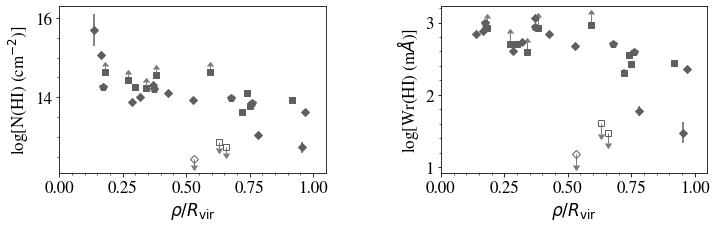

In [9]:
fig, ax1, ax2 = plot_pymc3_data(ion_label, fs=17, panel_stack='parallel', 
                          color=plt.cm.Greys(0.7))
#ax2.legend(fontsize=10, bbox_to_anchor=(1.0, 1.))

# fig.savefig('/Users/Yong/Desktop/test.pdf')

## First do quick fitting and treat non-detections as measurements to gauge the range of parameters. <br>
We fit the log-log values instead of their linear values because in this way we'll just do a simple y=mx+b linear fit instead of fitting for the power law

In [10]:
from scipy.optimize import curve_fit 

if has_nondet & has_sat: 
    rn_data = np.concatenate([rn_det, rn_sat, rn_nondet])
    logrn_data = np.concatenate([logrn_det, logrn_sat, logrn_nondet])
    logN_data = np.concatenate([logN_det, logN_sat, logN_nondet])
    logwr_data = np.concatenate([logwr_det, logwr_sat, logwr_nondet])
elif has_nondet & np.logical_not(has_sat): 
    rn_data = np.concatenate([rn_det, rn_nondet])
    logrn_data = np.concatenate([logrn_det, logrn_nondet])
    logN_data = np.concatenate([logN_det, logN_nondet])
    logwr_data = np.concatenate([logwr_det, logwr_nondet])
elif np.logical_not(has_nondet) & has_sat: 
    rn_data = np.concatenate([rn_det, rn_sat])
    logrn_data = np.concatenate([logrn_det, logrn_sat])
    logN_data = np.concatenate([logN_det, logN_sat])
    logwr_data = np.concatenate([logwr_det, logwr_sat])
else: 
    rn_data = rn_det, rn_sat
    logrn_data = logrn_det, logrn_sat
    logN_data = logN_det, logN_sat
    logwr_data = logwr_det, logwr_sat

In [11]:
logN_popt, logN_pcov = curve_fit(linear_model, logrn_data, logN_data)
print(logN_popt, np.sqrt(np.diag(logN_pcov)))

logwr_popt, logwr_pcov = curve_fit(linear_model, logrn_data, logwr_data)
print(logwr_popt, np.sqrt(np.diag(logwr_pcov)))

[-2.02090748 13.25723493] [0.42277923 0.18015541]
[-1.15563039  2.08920946] [0.3516692  0.14985388]


In [12]:
plt_x = np.logspace(logrn_data.min(), logrn_data.max(), 50)
plt_logx = np.log10(plt_x)

plt_logN = linear_model(plt_logx, *logN_popt)
plt_logwr = linear_model(plt_logx, *logwr_popt)

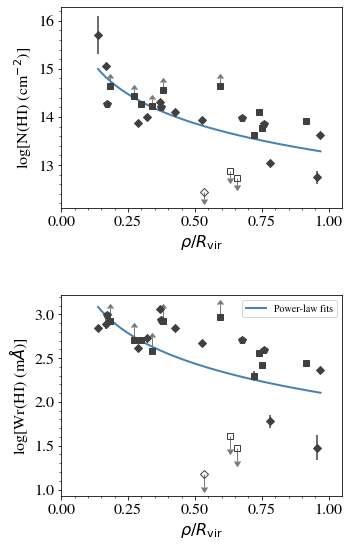

In [13]:
fig, ax1, ax2 = plot_pymc3_data(ion_label, fs=16)
ax1.plot(plt_x, plt_logN, label='Power-law fits', color='steelblue', lw=2)
ax2.plot(plt_x, plt_logwr, label='Power-law fits', color='steelblue', lw=2)
ax2.legend(fontsize=10, bbox_to_anchor=(1.0, 1.))

## Implementation of Bayesian Regression with censored data <br>
The goal of this Bayesian regression is the specification of a full probability model for the problem that we want to solve. In the linear regression regime, we want $Y\sim \mathcal{N}(X \beta, \sigma^2)$, where $Y$ is viewed as a random vector of which each data point is distributed according to a Normal distribution. The mean of this normal distribution is provided by the linear predictor $X\beta$ with variance $\sigma^2$ <br>
* First, prior for the parameters/coefficients: assign parametric statistical distributions to unknown quantities in the model (e.g., assign a normal-distribution prior for "slope" & "intercept" in the linear_func model), also set prior to $\sigma$ <br>
* Second, likelihood function to represent the information from the data <br>

Reading materials: <br>
https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-truncated-censored-regression.html <br>
https://docs.pymc.io/en/v3/Probability_Distributions.html<br>
https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-linear.html <br>

In [14]:
def censored_regression_model(ion, yname, x_det, y_det, ey_det, 
                              x_nondet, y_nondet,
                              model_form, 
                              init_para1, para1_bounds, 
                              init_para2, para2_bounds, 
                              x_sat=np.array([]), 
                              y_sat=np.array([])):
    """
    para1 = slope
    para2 = intercept 
    """

    with pm.Model() as model:
        # para1 = pm.Normal("para1", mu=init_para1, sigma=100)
        # para2 = pm.Normal("para2", mu=init_para2, sigma=1000)
        para1 = pm.TruncatedNormal("para1", 
                                   mu=init_para1, 
                                   sigma=10, # 10, 
                                   lower=para1_bounds[0], 
                                   upper=para1_bounds[1])
        para2 = pm.TruncatedNormal("para2", 
                                   mu=init_para2, 
                                   sigma=10, # 10, 
                                   lower=para2_bounds[0], 
                                   upper=para2_bounds[1])
        ##### for detections ##### 
        if len(y_det)!=0: 
            y_std = np.sqrt(np.mean(ey_det)**2 + np.std(y_det)**2) # measurement error plus intrinsic scatter
            if y_std == 0.: 
                y_std = 0.1
            y_likelihood = pm.TruncatedNormal("y_likelihood", 
                                              mu=model_form(x_det, para1, para2), 
                                              sigma=y_std, 
                                              observed=y_det, 
                                              lower=np.nanmin(y_nondet))
        else: 
            y_std = np.nan
        
        ###### for non-detections ####### 
        # y_std_nondet = np.std(y_nondet) # intrinsic scatter, but most likely due to SNR differences
        if np.isfinite(y_std): 
            y_std_nondet = y_std # assume the non detections have the same intrinsic scatter as detections
        else: 
            y_std_nondet = np.nanstd(y_nondet) # assume intrinsic scatter in non dets,
        left_censored = pm.Potential("left_censored", 
                                     normal_lcdf(model_form(x_nondet, para1, para2), 
                                                 y_std_nondet, y_nondet))
        ##### for saturation data ####### 
        if len(y_sat)!=0: 
            if np.isfinite(y_std): 
                y_std_sat = y_std # assume the saturation case have same intrinsic scatter as detectin 
            else: 
                y_std_sat = np.nanstd(y_sat) # assume intrinsic scatter in sat data points 
            right_censored = pm.Potential("right_censored", 
                                          normal_lccdf(model_form(x_sat, para1, para2),
                                                       y_std_sat, y_sat))
    return model

In [15]:
ndraws = 5000
ntune = 2000

For logN vs rvir fitting 

In [16]:
# set up initial parameter 
logN_init_p1 = logN_popt[0] # slope 
logN_init_p2 = logN_popt[1] # intercept 
logN_p1_bounds = [-10, 0]#[-10, 0]
logN_p2_bounds = [1, 100]# [logN_nondet.min()/10., 100]#[logN_nondet.min()/10., 100]

if has_sat: 
    x_sat, y_sat = logrn_sat, logN_sat
else: 
    x_sat, y_sat = np.array([]), np.array([])
    
# run logN 
logN_censored_model = censored_regression_model(ion, 'logN', logrn_det, logN_det, elogN_det, 
                                                logrn_nondet, logN_nondet, 
                                                linear_model, 
                                                logN_init_p1, logN_p1_bounds, 
                                                logN_init_p2, logN_p2_bounds, 
                                                x_sat=x_sat, y_sat=y_sat)

with logN_censored_model:
    logN_censored_fit = pm.sample(return_inferencedata=True, draws=ndraws, tune=ntune)

/Users/Yong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/Yong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/Yong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/Yong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufu

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8845867431664836, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


For EW vs fitting 

In [17]:
# set up initial parameter 
logwr_init_p1 = logwr_popt[0]
logwr_init_p2 = logwr_popt[1]
logwr_p1_bounds = [-10, 0]
logwr_p2_bounds = [-4, 100] # [logwr_nondet.min()/10., 100]

if has_sat: 
    x_sat, y_sat = logrn_sat, logwr_sat
else: 
    x_sat, y_sat = np.array([]), np.array([])
    
# run model 
logwr_censored_model = censored_regression_model(ion, 'logWr', logrn_det, logwr_det, elogwr_det, 
                                                logrn_nondet, logwr_nondet, 
                                                linear_model, 
                                                logwr_init_p1, logwr_p1_bounds, 
                                                logwr_init_p2, logwr_p2_bounds, 
                                                x_sat=x_sat, y_sat=y_sat)
with logwr_censored_model:
    logwr_censored_fit = pm.sample(return_inferencedata=True, draws=ndraws, tune=ntune)

/Users/Yong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/Yong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/Yong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/Yong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/Yong/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encounter

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.9126114065245386, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5939781273861279, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


## Save chain and posterior 

In [18]:
def save_chain(censored_fit, colnames=['slope', 'intercept', 'logp'], 
               savename='/Users/Yong/Desktop/test_chain'):
    import pandas as pd
    chainfile = '{}.feather'.format(savename)
    
    post = censored_fit.posterior
    para1_chain = censored_fit.posterior['para1'].values.flatten()
    para2_chain = censored_fit.posterior['para2'].values.flatten()
    logp_chain = censored_fit.sample_stats.lp.values.flatten()
    
    flat_chain = {'slope': para1_chain, 
                  'intercept': para2_chain, 
                  'logp': logp_chain}
    flat_chain_df = pd.DataFrame(flat_chain)
    flat_chain_df.to_feather(chainfile)
    
    print(chainfile)
    
    return chainfile

In [19]:
logN_chainfile = save_chain(logN_censored_fit, savename='./data/pymc3/pymc3_{}_chain_logN_{}'.format(ion, file_label))
logwr_chainfile = save_chain(logwr_censored_fit, savename='./data/pymc3/pymc3_{}_chain_logWr_{}'.format(ion, file_label))

./data/pymc3/pymc3_HI_chain_logN_use3sig.feather
./data/pymc3/pymc3_HI_chain_logWr_use3sig.feather


## Plots

First read in chain file is there is one 

In [20]:
logN_labels = [r'$\alpha_N$', r'$\log N_0$']
logwr_labels = [r'$\alpha_{Wr}$', r'$\log Wr_0$']

In [21]:
logN_chainfile = './data/pymc3/pymc3_{}_chain_logN_{}.feather'.format(ion, file_label)
logwr_chainfile = './data/pymc3/pymc3_{}_chain_logWr_{}.feather'.format(ion, file_label)

Get 16th, 50th,and 84th percentile 

In [22]:
from load_cgm_dwarf_mod import get_percentile
logN_p50 = get_percentile(logN_chainfile, labels=logN_labels)
logwr_p50 = get_percentile(logwr_chainfile, labels=logwr_labels)

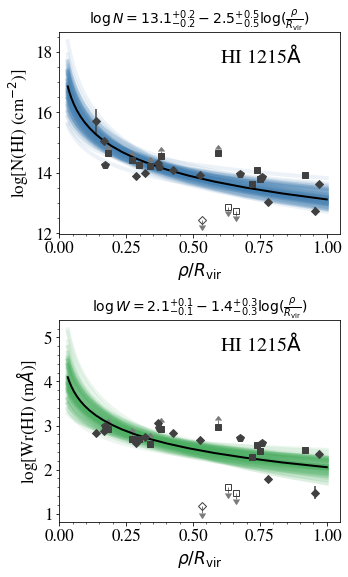

In [23]:
from load_cgm_dwarf_mod import plot_posterior

fig, ax1, ax2 = plot_pymc3_data(ion_label, fs=17)
plot_posterior(ax1, logN_chainfile, logN_p50, linear_model, nlines=100)
plot_posterior(ax2, logwr_chainfile, logwr_p50, linear_model, nlines=100, c=plt.cm.Greens(0.6))

a1 = np.around(logN_p50[0, 1], decimals=1)
b1 = np.around(logN_p50[2, 1], decimals=1)
c1 = np.around(logN_p50[1, 1], decimals=1)
d1 = np.around(logN_p50[0, 0], decimals=1) 
e1 = np.around(logN_p50[2, 0], decimals=1) 
f1 = np.around(logN_p50[1, 0], decimals=1) 
txt1 = r'$\log N=%.1f^{+%.1f}_{%.1f}%.1f^{+%.1f}_{%.1f}\log(\frac{\rho}{R_{\rm vir}})$'%(a1, b1, c1, d1, e1, f1)

a2 = np.around(logwr_p50[0, 1], decimals=1)
b2 = np.around(logwr_p50[2, 1], decimals=1)
c2 = np.around(logwr_p50[1, 1], decimals=1)
d2 = np.around(logwr_p50[0, 0], decimals=1)
e2 = np.around(logwr_p50[2, 0], decimals=1)
f2 = np.around(logwr_p50[1, 0], decimals=1)
txt2 = r'$\log W=%.1f^{+%.1f}_{%.1f}%.1f^{+%.1f}_{%.1f}\log(\frac{\rho}{R_{\rm vir}})$'%(a2, b2, c2, d2, e2, f2)
ax1.set_title(txt1, fontsize=14)
ax2.set_title(txt2, fontsize=14)
#if ion == 'HI': 
#    ax2.legend(fontsize=10, bbox_to_anchor=(1.0, 1.))

for ax in [ax1, ax2]: 
    ymin, ymax = ax.get_ylim()
    ax.text(0.6, ymin+(ymax-ymin)*0.85, ion_label, fontsize=20)
        
fig.savefig('./data/pymc3/pymc3_{}_logN_logWr_rho_{}_stack.pdf'.format(ion, file_label))

Chain plots

In [24]:
def chain_plot(chainfile, labels=["slope", "intercept"], fs=10, 
               figname='/Users/Yong/Desktop/test_trace.pdf'):
    
    import pandas as pd 
    chain_data = pd.read_feather(chainfile)
    para1_chain = np.asarray(chain_data.slope)
    para2_chain = np.asarray(chain_data.intercept)
    flat_chain = [para1_chain, para2_chain]
    
    fig, axes = plt.subplots(3, figsize=(5, 6), sharex=True)
    colors = ['k', 'k']
    for i in range(len(flat_chain)): 
        ax = axes[i]
        ax.plot(flat_chain[i], alpha=0.3, lw=0.5, color=colors[i])
        ax.set_xlim(0, len(flat_chain[i]))
        ax.set_ylabel(labels[i], fontsize=fs)
        
    ax = axes[-1]
    logp_chain = np.asarray(chain_data.logp)
    ax.plot(logp_chain, alpha=0.3, lw=0.5, color='r')
    ax.set_xlim(0, len(logp_chain))
    ax.set_ylabel('logp', fontsize=fs)
    ax.set_xlabel('trace number', fontsize=fs) 
    fig.tight_layout()
    plt.savefig(figname, dpi=250)

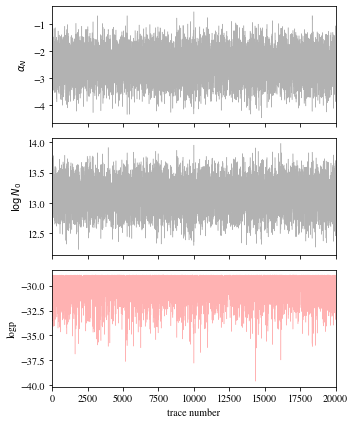

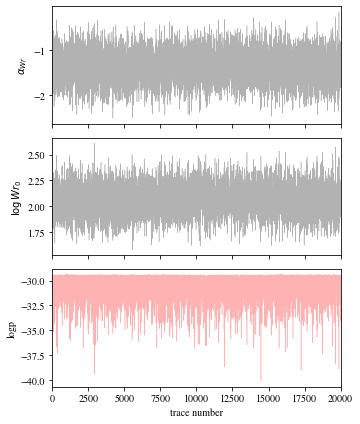

In [25]:
chain_plot(logN_chainfile, figname='./data/pymc3/pymc3_{}_trace_logN_{}.pdf'.format(ion, file_label), 
           labels=logN_labels)
chain_plot(logwr_chainfile, figname='./data/pymc3/pymc3_{}_trace_logWr_{}.pdf'.format(ion, file_label), 
           labels=logwr_labels)

Corner plots

In [26]:
def plt_corner(chainfile, labels=["slope", "intercept"], 
               figname='/Users/Yong/Desktop/test_corner.pdf'): 
    import corner
    import pandas as pd 
    flat_chain = pd.read_feather(chainfile)
    para1_chain = np.asarray(flat_chain.slope)
    para2_chain = np.asarray(flat_chain.intercept)
    
    aa = np.asarray([para1_chain, para2_chain]).T
    
    fig = corner.corner(aa, labels=labels,
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 12})
    fig.savefig(figname)

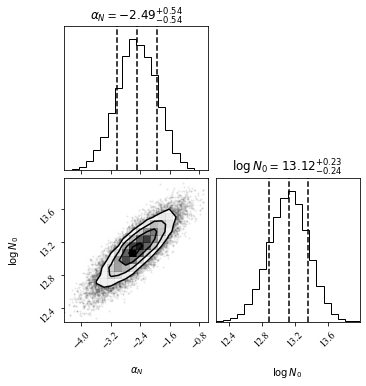

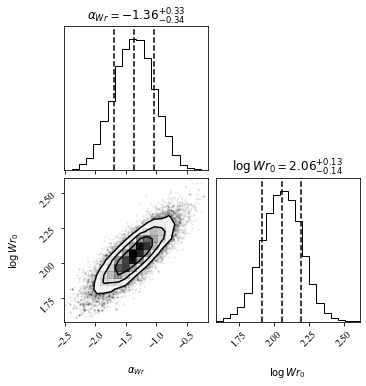

In [27]:
plt_corner(logN_chainfile, labels=logN_labels, figname='./data/pymc3/pymc3_{}_corner_logN_{}.pdf'.format(ion, file_label))
plt_corner(logwr_chainfile, labels=logwr_labels, figname='./data/pymc3/pymc3_{}_corner_logWr_{}.pdf'.format(ion, file_label))